In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

import random

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 25

Task: To predict whether the subject shows traits for Autism or not. <br>
Assumption: If the average percentage of points(reciprocity) scored in test is <=25 threshold, then the user shows traits for Autism, otherwise not.

In [5]:
#!wget https://www.dropbox.com/s/43lkf9ekh4r06mc/train.csv?dl=0
#!wget https://www.dropbox.com/s/q75gblch7wmsqok/test.csv?dl=0

--2019-04-07 14:15:29--  https://www.dropbox.com/s/43lkf9ekh4r06mc/train.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/43lkf9ekh4r06mc/train.csv [following]
--2019-04-07 14:15:30--  https://www.dropbox.com/s/raw/43lkf9ekh4r06mc/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d5fff73bdad376cf97f977af6.dl.dropboxusercontent.com/cd/0/inline/Aenvwe0av5bILMk7iyde8gE0g9110PO_uYU0Mc_YbtrTINk6H_qgGaOMs4BoHXPMxRTks35fPwkrKRq3FIUsjQwcDPyeZo0QrxGsl1anipGq4A/file# [following]
--2019-04-07 14:15:30--  https://uc8d5fff73bdad376cf97f977af6.dl.dropboxusercontent.com/cd/0/inline/Aenvwe0av5bILMk7iyde8gE0g9110PO_uYU0Mc_YbtrTINk6H_qgGaOMs4BoHXPMxRTks35fPwkrKRq3FIUsjQwcDPyeZo0QrxGsl1anipGq4A/file
Resolving uc8d5fff73bda

In [6]:
# read data from file
train = pd.read_csv("train.csv?dl=0") 
test = pd.read_csv("test.csv?dl=0")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 286
Number of features in train: 6
Number of data points in test: 75
Number of features in test: 5


# Removing unecessary features

In [8]:
# one hot encoding

train_ids = train['ID']
test_ids = test['ID']

cols = list(test.columns)
cols.remove('ID')
cols.insert(0, 'ID')

combined = pd.concat([train.drop('percentage', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['ID'].isin(train_ids)]
test_new = combined[combined['ID'].isin(test_ids)]

(361, 5)
Index(['ID', 'point_one', 'point_two', 'point_three', 'point_four'], dtype='object')
(361, 5)
Index(['ID', 'point_one', 'point_two', 'point_three', 'point_four'], dtype='object')


In [0]:
train_new = train_new.merge(train[['ID', 'percentage']], on='ID')

In [10]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 287
Number of features in train: 6
Number of data points in test: 76
Number of features in test: 5


#### Perform the head operation to get a feel for the test & train data and make basic observations

In [12]:
train_new.head()
# There is a ID column which is an indicator column and does not play any role decision making.


,ID,point_one,point_two,point_three,point_four,percentage
0,39,0,1,1,0,50
1,40,1,0,0,1,50
2,41,1,0,1,0,50
3,42,0,0,1,1,50
4,43,1,1,0,0,50


In [13]:
test_new.head()
# There is a ID column which is an indicator column and does not play any role decision making
# There is no percentage column in test_new since this will have to predict by building a working model
# on the train_data

,ID,point_one,point_two,point_three,point_four
105,180,1,1,1,1
0,81,0,0,0,0
1,83,0,0,0,0
2,87,0,0,0,0
3,88,0,0,0,0


### Create staging DataFrames

In [0]:
# Create X_train which will hold all columns except ID and percentage using train_new
# Create Y_train which will only hold the percentage column present in train_new, note that the dataframe maintains integrity of the PhoneID 
# which is very essential

# Create X_test which will hold all columns except ID
# There is no Y_test for obvious reasons as this is what you will be predicting 

X_train = train_new.drop(['ID','percentage'],axis=1)
Y_train = train_new['percentage'].map(lambda x: 1 if x <= 25 else 0) # Notice that if reciprocity % <=25 then shows traits for Autism

X_test = test_new.drop(['ID'],axis=1)

### The Perceptron Model

In [15]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(X_train))
MinMaxScaler(copy=True, feature_range=(0, 1))

X_train = scaler.transform(X_train)

scaler = MinMaxScaler()
print(scaler.fit(X_test))
MinMaxScaler(copy=True, feature_range=(0, 1))

X_test = scaler.transform(X_test)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


### X_train Standardized

In [16]:
X_train[0:1]

array([[0., 1., 1., 0.]])

In [0]:
class Perceptron:
    def __init__ (self):
        self.w = None
        self.b = None
 
    def model(self, x):
        return 1 if (np.dot(self.w, x) >= self.b) else 0
    
    def predict(self,X):
        Y = []
        for x in X:
            result=self.model(x)
            Y.append(result)
        return np.array(Y)
    
    def fit(self,X, Y, epochs = 1, lr = 1):
        #Weights = 0
        self.w = np.ones(X.shape[1]) #np.random.rand(73)
        self.b = 0 #random.randint(0,1)
        
        accuracy = {}
        max_accuracy = 0
        
        for i in range(epochs):
            for x,y in zip(X, Y):
                y_pred = self.model(x)
                if y==1 and y_pred ==0 :
                    self.w = self.w + lr * x
                    self.b = self.b - lr * 1
                #elif y==1 and y_pred == 1:
                    #self.w = self.w
                    #self.b = self.b
                #elif y==0 and y_pred == 0:
                    #self.w = self.w
                    #self.b = self.b
                elif y==0 and y_pred ==1:
                    self.w = self.w - lr * x
                    self.b = self.b + lr * 1
            accuracy[i] = accuracy_score(self.predict(X),Y)
            if (accuracy[i] > max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
            #    self.var = self.var - 1
            #elif (accuracy[i] < max_accuracy):
            #    self.var = self.var + 1
                
        self.w = chkptw
        self.b = chkptb
        
        print(max_accuracy)
        #print(self.var)
        print(self.w)
        plt.plot(accuracy.values())
        plt.ylim([0,1])
        plt.show()

In [0]:
perceptron = Perceptron()

### Epochs and Learning Rate
#### Best practise is to adjust Epochs and Learning rate in steps to improve accuracy. I used a high epoch value and a lower learning rate to stablize the model. You can try with other epoch values and observe the curve.

1.0
[-0.02 -0.01 -0.02 -0.02]


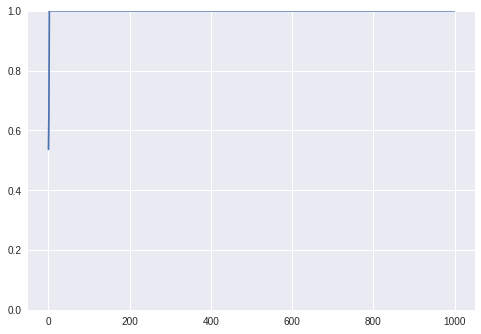

In [19]:
perceptron.fit(X_train,Y_train,1000,.01)

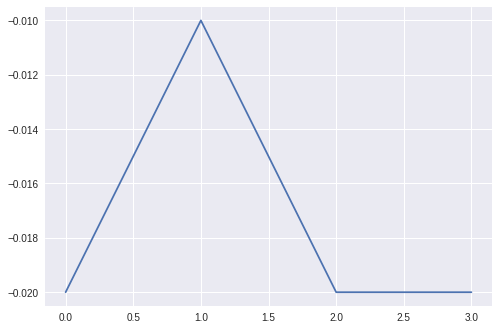

In [20]:
plt.plot(perceptron.w)
plt.show()

In [0]:
Y_pred_train = perceptron.predict(X_train)

In [22]:
Y_pred_test = perceptron.predict(X_test)
Y_pred_test = list(Y_pred_test)
print(Y_pred_test)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
submission = pd.DataFrame({'ID':test_new['ID'], 'Autism_trait':Y_pred_test})
submission = submission[['ID', 'Autism_trait']]
submission.head()

,ID,Autism_trait
105,180,0
0,81,1
1,83,1
2,87,1
3,88,1


In [0]:
submission.to_csv("submission.csv", index=False)

### References

##### 1. Course on Deep learning by Onefourthlabs
